## Commodity Futures Calendar Spread Backtesting Engine

### Project Overview
This Jupyter Notebook implements an event-driven backtesting framework for testing a Z-score based mean reversion strategy on commodity futures calendar spreads. The framework is modular, using real data (soybean meal, WTI crude oil), including data processing, strategy generation, portfolio management, execution simulation, and performance analysis.

#### Main Components
- **Event-Driven Architecture**: Handles market updates, signals, orders, and fills.
- **Strategy**: CalendarSpreadZScoreStrategy, uses rolling Z-score to generate buy/sell spread signals.
- **Backtest Coordination**: Backtest class, runs the event loop and calculates performance metrics (such as Sharpe ratio, maximum drawdown).
- **Data Support**: Loads from CSV, supports AKShare real data and generated sample data.
- **Visualization**: Equity curve, spread behavior, and trading signal charts.

#### Dataset
- **Soybean Meal**: Downloaded using the Akshare API.
- **WTI crude oil**: Initially attempted to download via APIs from Nasdaq Data Link and yfinance, but after failures, manually obtained from Investing.com.



In [ ]:
import pandas as pd
import requests
import time
import queue
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf

In [ ]:
class Event:
    """Base class for all event types."""
    pass

class MarketEvent(Event):
    """Handles the event of receiving new market data."""
    def __init__(self):
        self.type = 'MARKET'

class SignalEvent(Event):
    """Handles the event of sending a signal from a strategy object."""
    def __init__(self, symbol, datetime, signal_type, strength=1.0):
        self.type = 'SIGNAL'
        self.symbol = symbol
        self.datetime = datetime
        self.signal_type = signal_type # 'LONG_SPREAD' or 'SHORT_SPREAD'
        self.strength = strength

class OrderEvent(Event):
    """Handles the event of sending an order to the execution system."""
    def __init__(self, symbol, order_type, quantity, direction):
        self.type = 'ORDER'
        self.symbol = symbol
        self.order_type = order_type # 'MKT' (market order) or 'LMT' (limit order)
        self.quantity = quantity
        self.direction = direction # 'BUY' or 'SELL'

class FillEvent(Event):
    """Encapsulates the execution of an order, i.e., a trade."""
    def __init__(self, timeindex, symbol, exchange, quantity, direction, fill_cost, commission=0.0):
        self.type = 'FILL'
        self.timeindex = timeindex
        self.symbol = symbol
        self.exchange = exchange
        self.quantity = quantity
        self.direction = direction
        self.fill_cost = fill_cost
        self.commission = commission

In [ ]:
class CSVDataHandler:
    """Reads data from CSV files and provides it bar by bar."""
    def __init__(self, events_queue, csv_path, symbols):
        self.events = events_queue
        self.csv_path = csv_path
        self.symbols = symbols
        self.symbol_data = {}
        self.latest_symbol_data = {}
        self.continue_backtest = True
        
        self._open_convert_csv_files()

    def _open_convert_csv_files(self):
        self.symbol_data = pd.read_csv(
            self.csv_path, header=0, index_col=0, parse_dates=True
        ).to_records(index=True)
        self.data_iterator = self.symbol_data.__iter__()

    def get_latest_bar(self, symbol):
        """Returns the latest bar data for a given trading symbol."""
        try:
            return self.latest_symbol_data[symbol]
        except KeyError:
            print("This trading symbol is not available in the historical dataset.")
            return None

    def update_bars(self):
        """Pushes the next bar from the data source to latest_symbol_data."""
        try:
            bar = next(self.data_iterator)
        except StopIteration:
            self.continue_backtest = False
            return
        
        # We use a single 'symbol' for spread pairs
        self.latest_symbol_data[self.symbols[0]] = bar
        self.events.put(MarketEvent())

In [ ]:
class CalendarSpreadZScoreStrategy:
    """
    A simple strategy for trading calendar spreads based on Z-score.
    """
    def __init__(self, data_handler, events_queue, symbol, lookback_window=60, z_threshold=2.0):
        self.data_handler = data_handler
        self.events = events_queue
        self.symbol = symbol
        self.lookback_window = lookback_window
        self.z_threshold = z_threshold
        
        self.spread_history = pd.Series(dtype=float)
        self.bought = False # A simple flag to track if we are in a position
        self.sold = False

    def calculate_signals(self, event):
        """Calculate signals upon receiving a MarketEvent."""
        if event.type == 'MARKET':
            bar = self.data_handler.get_latest_bar(self.symbol)
            if bar is not None:
                # Calculate spread: far-month price - near-month price
                spread = bar['FAR'] - bar['NEAR']
                self.spread_history[bar['Date']] = spread

                if len(self.spread_history) > self.lookback_window:
                    # Calculate rolling mean, standard deviation, and Z-score
                    rolling_mean = self.spread_history.rolling(window=self.lookback_window).mean().iloc[-1]
                    rolling_std = self.spread_history.rolling(window=self.lookback_window).std().iloc[-1]
                    
                    if rolling_std > 0: # Avoid division by zero
                        z_score = (spread - rolling_mean) / rolling_std

                        # --- Trading logic ---
                        # If we are not in a position
                        if not self.bought and not self.sold:
                            if z_score > self.z_threshold:
                                # Spread is unusually high -> sell spread (sell far-month, buy near-month)
                                signal = SignalEvent(self.symbol, bar['Date'], 'SHORT_SPREAD')
                                self.events.put(signal)
                                self.sold = True
                            elif z_score < -self.z_threshold:
                                # Spread is unusually low -> buy spread (buy far-month, sell near-month)
                                signal = SignalEvent(self.symbol, bar['Date'], 'LONG_SPREAD')
                                self.events.put(signal)
                                self.bought = True
                        
                        # If we are in a position, check for exit
                        elif self.sold and z_score < 0.5:
                            # Spread reverts to mean -> exit short position
                            signal = SignalEvent(self.symbol, bar['Date'], 'EXIT_SHORT')
                            self.events.put(signal)
                            self.sold = False
                        elif self.bought and z_score > -0.5:
                            # Spread reverts to mean -> exit long position
                            signal = SignalEvent(self.symbol, bar['Date'], 'EXIT_LONG')
                            self.events.put(signal)
                            self.bought = False

In [ ]:
class BasicPortfolio:
    """
    Manages positions, cash, and performance.
    Generates orders based on signals.
    """
    def __init__(self, data_handler, events_queue, start_date, initial_capital=100000.0):
        self.data_handler = data_handler
        self.events = events_queue
        self.start_date = start_date
        self.initial_capital = initial_capital

        # Positions is a dictionary mapping trading symbols to quantities
        # For a spread, we hold two positions: e.g., {'NEAR': 10, 'FAR': -10}
        self.current_positions = {'NEAR': 0, 'FAR': 0}
        
        # Holdings is a dictionary tracking the portfolio's value over time
        self.all_holdings = []
        self.current_holdings = self._construct_current_holdings()

    def _construct_current_holdings(self):
        """Constructs the dictionary for current holdings."""
        d = {'datetime': self.start_date, 'cash': self.initial_capital, 'commission': 0.0, 'total': self.initial_capital}
        return d
    
    def update_timeindex(self, event):
        """
        Updates the portfolio's holdings value when a new market bar arrives.
        This is our mark-to-market calculation.
        """
        if event.type == 'MARKET':
            bar = self.data_handler.get_latest_bar(self.data_handler.symbols[0])
            dt = bar['Date']
            
            # Update holdings dictionary
            self.current_holdings['datetime'] = dt
            
            # Update total value
            total_value = self.current_holdings['cash']
            total_value += self.current_positions['NEAR'] * bar['NEAR']
            total_value += self.current_positions['FAR'] * bar['FAR']
            self.current_holdings['total'] = total_value
            
            # Add to the list of all holdings
            self.all_holdings.append(self.current_holdings.copy())

    def update_positions_from_fill(self, fill):
        """Receives a FillEvent and updates the positions dictionary."""
        fill_dir = 1 if fill.direction == 'BUY' else -1
        
        # FillEvent's 'symbol' will be 'NEAR' or 'FAR'
        self.current_positions[fill.symbol] += fill_dir * fill.quantity

    def update_holdings_from_fill(self, fill):
        """Receives a FillEvent and updates the holdings dictionary."""
        fill_dir = 1 if fill.direction == 'BUY' else -1
        
        # Update cash
        cost = fill.fill_cost * fill_dir
        self.current_holdings['cash'] -= (cost + fill.commission)
        self.current_holdings['commission'] += fill.commission

    def generate_naive_order(self, signal):
        """
        Simply converts a Signal object into OrderEvents for both legs of the spread.
        Uses a fixed quantity for simplicity.
        """
        if signal.type == 'SIGNAL':
            quantity = 10 # Use a fixed quantity in this simple model
            
            if signal.signal_type == 'LONG_SPREAD': # Buy far-month, sell near-month
                order_far = OrderEvent('FAR', 'MKT', quantity, 'BUY')
                order_near = OrderEvent('NEAR', 'MKT', quantity, 'SELL')
            elif signal.signal_type == 'SHORT_SPREAD': # Sell far-month, buy near-month
                order_far = OrderEvent('FAR', 'MKT', quantity, 'SELL')
                order_near = OrderEvent('NEAR', 'MKT', quantity, 'BUY')
            elif signal.signal_type == 'EXIT_LONG': # Close long spread -> sell far-month, buy near-month
                order_far = OrderEvent('FAR', 'MKT', self.current_positions['FAR'], 'SELL')
                order_near = OrderEvent('NEAR', 'MKT', abs(self.current_positions['NEAR']), 'BUY')
            elif signal.signal_type == 'EXIT_SHORT': # Close short spread -> buy far-month, sell near-month
                order_far = OrderEvent('FAR', 'MKT', abs(self.current_positions['FAR']), 'BUY')
                order_near = OrderEvent('NEAR', 'MKT', self.current_positions['NEAR'], 'SELL')
            
            self.events.put(order_far)
            self.events.put(order_near)

    def create_equity_curve_dataframe(self):
        """Creates a pandas DataFrame from the all_holdings list."""
        curve = pd.DataFrame(self.all_holdings)
        curve.set_index('datetime', inplace=True)
        curve['returns'] = curve['total'].pct_change()
        curve['equity_curve'] = (1.0 + curve['returns']).cumprod()
        return curve

In [ ]:
class SimulatedExecutionHandler:
    """
    Simulates the execution of orders, including slippage and commission.
    """
    def __init__(self, events_queue, data_handler, commission_per_trade=5.0, slippage_per_trade=0.01):
        self.events = events_queue
        self.data_handler = data_handler
        self.commission = commission_per_trade
        self.slippage = slippage_per_trade

    def execute_order(self, event):
        """
        Receives an OrderEvent and converts it into a FillEvent.
        """
        if event.type == 'ORDER':
            # Get the current market price of the contract leg being traded
            bar = self.data_handler.get_latest_bar(self.data_handler.symbols[0])
            price = bar[event.symbol]
            
            # Apply slippage
            if event.direction == 'BUY':
                fill_price = price + self.slippage
            else: # SELL
                fill_price = price - self.slippage
            
            fill_cost = fill_price * event.quantity
            
            fill_event = FillEvent(
                bar['Date'], event.symbol, 'SIMULATED', 
                event.quantity, event.direction, fill_cost, self.commission
            )
            self.events.put(fill_event)

In [ ]:
class Backtest:
    """
    Main backtest coordinator.
    """
    def __init__(
        self, csv_path, symbol, initial_capital, lookback, z_score,
        start_date, data_handler_cls, strategy_cls, portfolio_cls, execution_handler_cls
    ):
        self.events = queue.Queue()
        self.csv_path = csv_path
        self.symbol_list = [symbol]
        self.initial_capital = initial_capital
        self.start_date = start_date
        
        self.data_handler = data_handler_cls(self.events, self.csv_path, self.symbol_list)
        self.strategy = strategy_cls(self.data_handler, self.events, symbol, lookback, z_score)
        self.portfolio = portfolio_cls(self.data_handler, self.events, self.start_date, self.initial_capital)
        self.execution_handler = execution_handler_cls(self.events, self.data_handler)
        
    def _run_backtest(self):
        """Main event loop."""
        print("Running backtest...")
        while True:
            # Update bars (push a MarketEvent if new data is available)
            self.data_handler.update_bars()
            
            if not self.data_handler.continue_backtest:
                break
                
            while True:
                try:
                    event = self.events.get(False)
                except queue.Empty:
                    break
                else:
                    if event is not None:
                        if event.type == 'MARKET':
                            self.portfolio.update_timeindex(event)
                            self.strategy.calculate_signals(event)
                        elif event.type == 'SIGNAL':
                            self.portfolio.generate_naive_order(event)
                        elif event.type == 'ORDER':
                            self.execution_handler.execute_order(event)
                        elif event.type == 'FILL':
                            self.portfolio.update_positions_from_fill(event)
                            self.portfolio.update_holdings_from_fill(event)
        print("Backtest completed.")

    def simulate_trading(self):
        """Simulates trading and returns performance statistics."""
        self._run_backtest()
        return self.portfolio.create_equity_curve_dataframe()

def plot_performance(performance, strategy, title):
    """Plots the performance charts of the backtest."""
    
    # 1. Equity curve
    fig = plt.figure(figsize=(12, 16))
    fig.suptitle(title, fontsize=16)
    
    ax1 = fig.add_subplot(311)
    ax1.plot(performance['equity_curve'], label='Equity Curve')
    ax1.set_title('Portfolio Equity Curve')
    ax1.set_ylabel('Cumulative Return')
    ax1.grid(True)
    ax1.legend()
    
    # 2. Spread and rolling mean
    ax2 = fig.add_subplot(312)
    spread = strategy.spread_history
    mean = spread.rolling(window=strategy.lookback_window).mean()
    ax2.plot(spread.index, spread.values, label='Spread (Far - Near)')
    ax2.plot(mean.index, mean.values, label=f'{strategy.lookback_window}-Day Rolling Mean', linestyle='--')
    ax2.set_title('Spread and Rolling Mean')
    ax2.set_ylabel('Price Difference')
    ax2.grid(True)
    ax2.legend()
    
    # 3. Z-score and trading signals
    ax3 = fig.add_subplot(313)
    z_score = (spread - mean) / spread.rolling(window=strategy.lookback_window).std()
    ax3.plot(z_score.index, z_score.values, label='Z-Score')
    ax3.axhline(strategy.z_threshold, color='r', linestyle='--', label=f'Threshold ({strategy.z_threshold})')
    ax3.axhline(-strategy.z_threshold, color='r', linestyle='--')
    ax3.axhline(0.0, color='k', linestyle='-')
    
    # Plot entry/exit points
    trade_points = performance[performance['commission'] > 0]
    buy_signals = trade_points[trade_points['returns'].notna()] # Rough method to identify entry points
    
    ax3.plot(z_score.loc[buy_signals.index].index, z_score.loc[buy_signals.index], '^', color='g', markersize=10, label='Entry Points')
    # Note: More robust plotting of trade points requires storing trade objects.
    
    ax3.set_title('Spread Z-Score and Trading Signals')
    ax3.set_ylabel('Z-Score')
    ax3.set_xlabel('Date')
    ax3.grid(True)
    ax3.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def calculate_performance_metrics(performance):
    """Calculates and prints key performance metrics."""
    total_return = performance['equity_curve'].iloc[-1] - 1
    sharpe_ratio = performance['returns'].mean() / performance['returns'].std() * np.sqrt(252) # Annualized
    
    # Maximum drawdown
    cum_returns = performance['equity_curve']
    running_max = np.maximum.accumulate(cum_returns)
    drawdown = (cum_returns - running_max) / running_max
    max_drawdown = drawdown.min()
    
    print(f"Total Return: {total_return:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")

In [ ]:
# Modified data handler to process real data
class RealCSVDataHandler:
    """Enhanced CSV data handler adapted for real futures data format."""
    def __init__(self, events_queue, csv_path, symbols):
        self.events = events_queue
        self.csv_path = csv_path
        self.symbols = symbols
        self.symbol_data = {}
        self.latest_symbol_data = {}
        self.continue_backtest = True
        
        self._open_convert_csv_files()

    def _open_convert_csv_files(self):
        # Read CSV file, first column is the date index
        df = pd.read_csv(self.csv_path, index_col=0, parse_dates=True)
        
        # Ensure column names are correct
        if 'NEAR' not in df.columns or 'FAR' not in df.columns:
            raise ValueError(f"CSV file must contain 'NEAR' and 'FAR' columns. Current columns: {df.columns.tolist()}")
        
        # Convert to records format, including index
        self.symbol_data = df.to_records(index=True)
        self.data_iterator = iter(self.symbol_data)
        
        print(f"   Successfully loaded data file: {self.csv_path}")
        print(f"   • Data shape: {df.shape}")
        print(f"   • Date range: {df.index.min()} to {df.index.max()}")
        print(f"   • Columns: {df.columns.tolist()}")

    def get_latest_bar(self, symbol):
        """Returns the latest bar data for a given trading symbol."""
        try:
            return self.latest_symbol_data[symbol]
        except KeyError:
            print("This trading symbol is not available in the historical dataset.")
            return None

    def update_bars(self):
        """Pushes the next bar from the data source to latest_symbol_data."""
        try:
            bar = next(self.data_iterator)
        except StopIteration:
            self.continue_backtest = False
            return
        
        # We use a single 'symbol' for spread pairs
        self.latest_symbol_data[self.symbols[0]] = bar
        self.events.put(MarketEvent())

# Also update Portfolio class to handle correct date field
class RealBasicPortfolio:
    """
    Enhanced portfolio manager adapted for real data format.
    """
    def __init__(self, data_handler, events_queue, start_date, initial_capital=100000.0):
        self.data_handler = data_handler
        self.events = events_queue
        self.start_date = start_date
        self.initial_capital = initial_capital

        # Positions is a dictionary mapping trading symbols to quantities
        self.current_positions = {'NEAR': 0, 'FAR': 0}
        
        # Holdings is a dictionary tracking the portfolio's value over time
        self.all_holdings = []
        self.current_holdings = self._construct_current_holdings()

    def _construct_current_holdings(self):
        """Constructs the dictionary for current holdings."""
        d = {'datetime': self.start_date, 'cash': self.initial_capital, 'commission': 0.0, 'total': self.initial_capital}
        return d
    
    def update_timeindex(self, event):
        """Updates the portfolio's holdings value when a new market bar arrives."""
        if event.type == 'MARKET':
            bar = self.data_handler.get_latest_bar(self.data_handler.symbols[0])
            
            # Get date - check field name
            if hasattr(bar, 'Date'):
                dt = bar['Date']
            elif hasattr(bar, 'index'):
                dt = bar['index']
            else:
                # If it's a numpy record, the index might be at position 0
                dt = bar[0] if len(bar) > 0 else self.current_holdings['datetime']
            
            # Update holdings dictionary
            self.current_holdings['datetime'] = dt
            
            # Update total value
            total_value = self.current_holdings['cash']
            total_value += self.current_positions['NEAR'] * bar['NEAR']
            total_value += self.current_positions['FAR'] * bar['FAR']
            self.current_holdings['total'] = total_value
            
            # Add to the list of all holdings
            self.all_holdings.append(self.current_holdings.copy())

    def update_positions_from_fill(self, fill):
        """Receives a FillEvent and updates the positions dictionary."""
        fill_dir = 1 if fill.direction == 'BUY' else -1
        self.current_positions[fill.symbol] += fill_dir * fill.quantity

    def update_holdings_from_fill(self, fill):
        """Receives a FillEvent and updates the holdings dictionary."""
        fill_dir = 1 if fill.direction == 'BUY' else -1
        
        # Update cash
        cost = fill.fill_cost * fill_dir
        self.current_holdings['cash'] -= (cost + fill.commission)
        self.current_holdings['commission'] += fill.commission

    def generate_naive_order(self, signal):
        """Simply converts a Signal object into OrderEvents for both legs of the spread."""
        if signal.type == 'SIGNAL':
            quantity = 10  # Use fixed quantity
            
            if signal.signal_type == 'LONG_SPREAD':  # Buy far-month, sell near-month
                order_far = OrderEvent('FAR', 'MKT', quantity, 'BUY')
                order_near = OrderEvent('NEAR', 'MKT', quantity, 'SELL')
            elif signal.signal_type == 'SHORT_SPREAD':  # Sell far-month, buy near-month
                order_far = OrderEvent('FAR', 'MKT', quantity, 'SELL')
                order_near = OrderEvent('NEAR', 'MKT', quantity, 'BUY')
            elif signal.signal_type == 'EXIT_LONG':  # Close long spread
                order_far = OrderEvent('FAR', 'MKT', self.current_positions['FAR'], 'SELL')
                order_near = OrderEvent('NEAR', 'MKT', abs(self.current_positions['NEAR']), 'BUY')
            elif signal.signal_type == 'EXIT_SHORT':  # Close short spread
                order_far = OrderEvent('FAR', 'MKT', abs(self.current_positions['FAR']), 'BUY')
                order_near = OrderEvent('NEAR', 'MKT', self.current_positions['NEAR'], 'SELL')
            
            self.events.put(order_far)
            self.events.put(order_near)

    def create_equity_curve_dataframe(self):
        """Creates a pandas DataFrame from the all_holdings list."""
        curve = pd.DataFrame(self.all_holdings)
        curve.set_index('datetime', inplace=True)
        curve['returns'] = curve['total'].pct_change()
        curve['equity_curve'] = (1.0 + curve['returns']).cumprod()
        return curve

# Update strategy class to handle correct date field
class RealCalendarSpreadZScoreStrategy:
    """Enhanced calendar spread Z-score strategy adapted for real data format."""
    def __init__(self, data_handler, events_queue, symbol, lookback_window=60, z_threshold=2.0):
        self.data_handler = data_handler
        self.events = events_queue
        self.symbol = symbol
        self.lookback_window = lookback_window
        self.z_threshold = z_threshold
        
        self.spread_history = pd.Series(dtype=float)
        self.bought = False
        self.sold = False

    def calculate_signals(self, event):
        """Calculate signals upon receiving a MarketEvent."""
        if event.type == 'MARKET':
            bar = self.data_handler.get_latest_bar(self.symbol)
            if bar is not None:
                # Get date
                if hasattr(bar, 'Date'):
                    bar_date = bar['Date']
                elif hasattr(bar, 'index'):
                    bar_date = bar['index']
                else:
                    bar_date = bar[0] if len(bar) > 0 else pd.Timestamp.now()
                
                # Calculate spread: far-month price - near-month price
                spread = bar['FAR'] - bar['NEAR']
                self.spread_history[bar_date] = spread

                if len(self.spread_history) > self.lookback_window:
                    # Calculate rolling mean, standard deviation, and Z-score
                    rolling_mean = self.spread_history.rolling(window=self.lookback_window).mean().iloc[-1]
                    rolling_std = self.spread_history.rolling(window=self.lookback_window).std().iloc[-1]
                    
                    if rolling_std > 0:  # Avoid division by zero
                        z_score = (spread - rolling_mean) / rolling_std

                        # --- Trading logic ---
                        if not self.bought and not self.sold:
                            if z_score > self.z_threshold:
                                # Spread is unusually high -> sell spread
                                signal = SignalEvent(self.symbol, bar_date, 'SHORT_SPREAD')
                                self.events.put(signal)
                                self.sold = True
                            elif z_score < -self.z_threshold:
                                # Spread is unusually low -> buy spread
                                signal = SignalEvent(self.symbol, bar_date, 'LONG_SPREAD')
                                self.events.put(signal)
                                self.bought = True
                        
                        # Check for exit
                        elif self.sold and z_score < 0.5:
                            signal = SignalEvent(self.symbol, bar_date, 'EXIT_SHORT')
                            self.events.put(signal)
                            self.sold = False
                        elif self.bought and z_score > -0.5:
                            signal = SignalEvent(self.symbol, bar_date, 'EXIT_LONG')
                            self.events.put(signal)
                            self.bought = False

print("Real data processing components updated successfully!")

Real data processing components updated successfully!


In [ ]:
# Fixed execution handler
class RealSimulatedExecutionHandler:
    """Enhanced simulated execution handler adapted for real data format."""
    def __init__(self, events_queue, data_handler, commission_per_trade=5.0, slippage_per_trade=0.01):
        self.events = events_queue
        self.data_handler = data_handler
        self.commission = commission_per_trade
        self.slippage = slippage_per_trade

    def execute_order(self, event):
        """Receives an OrderEvent and converts it into a FillEvent."""
        if event.type == 'ORDER':
            # Get the current market price of the contract leg being traded
            bar = self.data_handler.get_latest_bar(self.data_handler.symbols[0])
            price = bar[event.symbol]
            
            # Get date
            if hasattr(bar, 'Date'):
                bar_date = bar['Date']
            elif hasattr(bar, 'index'):
                bar_date = bar['index']
            else:
                bar_date = bar[0] if len(bar) > 0 else pd.Timestamp.now()
            
            # Apply slippage
            if event.direction == 'BUY':
                fill_price = price + self.slippage
            else:  # SELL
                fill_price = price - self.slippage
            
            fill_cost = fill_price * event.quantity
            
            fill_event = FillEvent(
                bar_date, event.symbol, 'SIMULATED', 
                event.quantity, event.direction, fill_cost, self.commission
            )
            self.events.put(fill_event)

print("Execution handler fixed successfully!")

Execution handler fixed successfully!


In [ ]:
class FixedRealFuturesDataFetcher:
    
    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        })
        
    def get_akshare_data_fixed(self, symbol):
        """
        Fixed AKShare data retrieval method
        
        Parameters:
        symbol: Futures symbol, e.g., 'Soybean Meal Continuous', 'Rebar Continuous'
        """
        try:
            # First check if akshare is installed
            try:
                import akshare as ak
                print(f"AKShare version: {ak.__version__}")
            except ImportError:
                print("Please install akshare first: pip install akshare")
                return None
            
            print(f"Fetching {symbol} data...")
            
            # Try different AKShare interfaces
            data = None
            
            # Method 1: Use Sina Finance interface
            try:
                if '豆粕' in symbol:
                    data = ak.futures_main_sina(symbol="豆粕连续")
                elif '螺纹钢' in symbol:
                    data = ak.futures_main_sina(symbol="螺纹钢连续")
                elif '白糖' in symbol:
                    data = ak.futures_main_sina(symbol="白糖连续")
                else:
                    data = ak.futures_main_sina(symbol=symbol)
                    
                if data is not None and not data.empty:
                    print("Successfully retrieved using Sina Finance interface")
                    
            except Exception as e:
                print(f"Sina Finance interface failed: {e}")
            
            # Method 2: Use East Money interface
            if data is None or data.empty:
                try:
                    if '豆粕' in symbol:
                        data = ak.futures_zh_daily_sina(symbol="M0")
                    elif '螺纹钢' in symbol:
                        data = ak.futures_zh_daily_sina(symbol="RB0")
                    
                    if data is not None and not data.empty:
                        print("Successfully retrieved using East Money interface")
                        
                except Exception as e:
                    print(f"East Money interface failed: {e}")
            
            # Method 3: Use alternative interface
            if data is None or data.empty:
                try:
                    # Try to get real-time futures data as a reference
                    data = ak.futures_display_main_sina()
                    print("Retrieved futures symbols list, but no historical data")
                    print("Available futures symbols:")
                    if not data.empty:
                        print(data[['symbol', 'name']].head(10))
                    return None
                    
                except Exception as e:
                    print(f"Alternative interface failed: {e}")
            
            if data is None or data.empty:
                print("All AKShare interfaces failed to retrieve data")
                return None
            
            # Data cleaning and standardization
            if 'date' in data.columns:
                data['date'] = pd.to_datetime(data['date'])
                data.set_index('date', inplace=True)
            elif 'datetime' in data.columns:
                data['datetime'] = pd.to_datetime(data['datetime'])
                data.set_index('datetime', inplace=True)
            
            data = data.sort_index()
            
            # Standardize column names
            column_mapping = {
                'open': 'open', 'high': 'high', 'low': 'low', 'close': 'close',
                'volume': 'volume', 'amount': 'amount'
            }
            
            available_columns = [col for col in column_mapping.keys() if col in data.columns]
            if available_columns:
                return data[available_columns]
            else:
                print(f"Column names do not match, current columns: {data.columns.tolist()}")
                return data
                
        except Exception as e:
            print(f"AKShare data retrieval failed: {e}")
            return None
    
    def get_tushare_data_with_retry(self, ts_code, start_date, end_date, token, max_retries=3):
        """
        Tushare data retrieval with retry mechanism
        """
        for attempt in range(max_retries):
            try:
                import tushare as ts
                pro = ts.pro_api(token)
                
                print(f"Attempting to fetch {ts_code} data (Attempt {attempt+1})")
                
                # Fetch futures daily data
                df = pro.fut_daily(
                    ts_code=ts_code,
                    start_date=start_date.replace('-', ''),
                    end_date=end_date.replace('-', ''),
                    limit=2000  # Limit records to avoid timeout
                )
                
                if df is not None and not df.empty:
                    # Data processing
                    df['trade_date'] = pd.to_datetime(df['trade_date'])
                    df = df.sort_values('trade_date')
                    df.set_index('trade_date', inplace=True)
                    
                    print(f"Tushare data retrieved successfully, {len(df)} records")
                    return df[['open', 'high', 'low', 'close', 'vol']]
                else:
                    print(f"Attempt {attempt+1} returned empty data")
                    
            except ImportError:
                print("Please install tushare first: pip install tushare")
                return None
            except Exception as e:
                print(f"Attempt {attempt+1} failed: {e}")
                if attempt < max_retries - 1:
                    time.sleep(2)  # Wait 2 seconds before retrying
                    
        print("All retries failed")
        return None
    
    def create_sample_real_data(self, symbol, start_date, end_date):
        """
        Creates sample data based on real market characteristics (fallback when APIs fail)
        """
        print(f"Creating sample data for {symbol} as a demonstration...")
        
        dates = pd.date_range(start=start_date, end=end_date, freq='B')
        num_days = len(dates)
        
        # Set different base prices and volatility based on symbol
        if '豆粕' in symbol or 'M' in symbol:
            base_price = 3200
            volatility = 0.025
        elif '螺纹钢' in symbol or 'RB' in symbol:
            base_price = 4000
            volatility = 0.03
        elif '原油' in symbol or 'CL' in symbol:
            base_price = 70
            volatility = 0.035
        else:
            base_price = 100
            volatility = 0.02
        
        # Generate price series
        np.random.seed(42)
        returns = np.random.normal(0, volatility, num_days)
        prices = base_price * np.exp(np.cumsum(returns))
        
        # Add some trend and seasonality
        trend = np.linspace(0, 0.1, num_days)
        seasonal = 0.05 * np.sin(2 * np.pi * np.arange(num_days) / 252)
        prices *= (1 + trend + seasonal)
        
        # Generate OHLC data
        high_factor = 1 + np.abs(np.random.normal(0, 0.01, num_days))
        low_factor = 1 - np.abs(np.random.normal(0, 0.01, num_days))
        
        data = pd.DataFrame({
            'open': prices * np.random.uniform(0.99, 1.01, num_days),
            'high': prices * high_factor,
            'low': prices * low_factor,
            'close': prices,
            'volume': np.random.randint(10000, 100000, num_days)
        }, index=dates)
        
        # Ensure OHLC logic is correct
        data['high'] = np.maximum.reduce([data['open'], data['high'], data['close']])
        data['low'] = np.minimum.reduce([data['open'], data['low'], data['close']])
        
        print(f"Sample data created successfully, {len(data)} records")
        print(f"   Price range: {data['close'].min():.2f} - {data['close'].max():.2f}")
        
        return data

# Create fixed data fetcher
fixed_fetcher = FixedRealFuturesDataFetcher()

print("Fixed data fetcher initialized successfully")

Fixed data fetcher initialized successfully


In [ ]:
# Test the fixed AKShare functionality
print("  Testing the fixed AKShare data retrieval")

def test_fixed_akshare():
    """Test the fixed AKShare data retrieval"""
    
    try:
        import akshare as ak
        print(f"AKShare installed, version: {ak.__version__}")
        
        # Test fetching soybean meal data
        print("\nTesting soybean meal futures data retrieval...")
        soybean_data = fixed_fetcher.get_akshare_data_fixed('Soybean Meal Continuous')
        
        if soybean_data is not None and not soybean_data.empty:
            print("Soybean meal data retrieved successfully!")
            print(f"Data shape: {soybean_data.shape}")
            print("Data preview:")
            print(soybean_data.head())
            
            # Save data
            soybean_data.to_csv('akshare_soybean_fixed.csv')
            print("Data saved to: akshare_soybean_fixed.csv")
            return soybean_data
        else:
            print("AKShare still unable to retrieve data, using fallback...")
            return None
            
    except ImportError:
        print("AKShare not installed")
        return None
    except Exception as e:
        print(f"AKShare test failed: {e}")
        return None

def test_backup_data_creation():
    """Test the fallback data creation scheme"""
    print("\nTesting fallback data creation...")
    
    # Create soybean sample data
    soybean_sample = fixed_fetcher.create_sample_real_data(
        '豆粕', '2022-01-01', '2024-12-31'
    )
    
    if soybean_sample is not None:
        print("Soybean meal sample data created successfully!")
        print(f"Data shape: {soybean_sample.shape}")
        print("Data preview:")
        print(soybean_sample.head())
        
        # Save sample data
        soybean_sample.to_csv('sample_soybean_data.csv')
        print("Sample data saved to: sample_soybean_data.csv")
        return soybean_sample
    
    return None

def create_demo_spread_data():
    """Create demo spread data"""
    print("\nCreating demo spread data...")
    
    # Create near-month and far-month contract data
    near_data = fixed_fetcher.create_sample_real_data(
        '豆粕近月', '2022-01-01', '2024-12-31'
    )
    
    # Far-month contracts typically have a premium
    far_data = near_data.copy()
    far_data['close'] *= 1.008  # 0.8% premium
    far_data['open'] *= 1.008
    far_data['high'] *= 1.008
    far_data['low'] *= 1.008
    
    print("Near-month and far-month contract data created")
    
    # Create spread data
    spread_data = pd.DataFrame({
        'NEAR': near_data['close'],
        'FAR': far_data['close']
    })
    
    spread_data['SPREAD'] = spread_data['FAR'] - spread_data['NEAR']
    
    # Save spread data
    spread_data[['NEAR', 'FAR']].to_csv('demo_spread_data.csv')
    
    print(f"Spread data created successfully!")
    print(f"   Data points: {len(spread_data)}")
    print(f"   Average spread: ${spread_data['SPREAD'].mean():.2f}")
    print(f"   Spread standard deviation: ${spread_data['SPREAD'].std():.2f}")
    print("Data saved to: demo_spread_data.csv")
    
    return spread_data

# Run tests
print("Starting all tests...")

# Test 1: Try AKShare
akshare_result = test_fixed_akshare()

# Test 2: Fallback data creation
backup_result = test_backup_data_creation()

# Test 3: Create demo spread data
spread_result = create_demo_spread_data()

print("\n" + "=" * 60)
print("Test results summary:")
print(f"   AKShare data retrieval: {'Success' if akshare_result is not None else 'Failed'}")
print(f"   Fallback data creation: {'Success' if backup_result is not None else 'Failed'}")
print(f"   Spread data creation: {'Success' if spread_result is not None else 'Failed'}")

if spread_result is not None:
    print(f"\nRecommended: Use demo_spread_data.csv for backtest demo")
    print(f"   This file contains futures spread data based on real market characteristics")
    print(f"   Can be directly used for your calendar spread strategy backtest")


  Testing the fixed AKShare data retrieval
Starting all tests...
AKShare installed, version: 1.17.19

Testing soybean meal futures data retrieval...
AKShare version: 1.17.19
Fetching Soybean Meal Continuous data...
Sina Finance interface failed: Expected object or value
Sina Finance interface failed: Expected object or value
Retrieved futures symbols list, but no historical data
Available futures symbols:
  symbol   name
0     V0  PVC连续
1     P0  棕榈油连续
2     B0   豆二连续
3     M0   豆粕连续
4     I0  铁矿石连续
5    JD0   鸡蛋连续
6     L0   塑料连续
7    PP0  聚丙烯连续
8    FB0  纤维板连续
9    BB0  胶合板连续
AKShare still unable to retrieve data, using fallback...

Testing fallback data creation...
Creating sample data for 豆粕 as a demonstration...
Sample data created successfully, 782 records
   Price range: 2288.18 - 4765.58
Soybean meal sample data created successfully!
Data shape: (782, 5)
Data preview:
                   open         high          low        close  volume
2022-01-03  3216.120127  3252.303235  32

Running calendar spread strategy backtest with real AKShare data
Starting complete real data backtest process...
Found AKShare real data file
Soybean meal data information:
   Data range: 2005-01-04 00:00:00 to 2025-08-15 00:00:00
   Data points: 5020
   Price range: $2087.00 - $4488.00
Backtest data range: 2022-01-04 00:00:00 to 2024-12-31 00:00:00
Backtest data points: 726
Real spread data saved to: real_akshare_spread_data.csv

Spread statistics:
   Average spread: $29.56
   Spread standard deviation: $8.43
   Spread range: $6.85 to $58.21


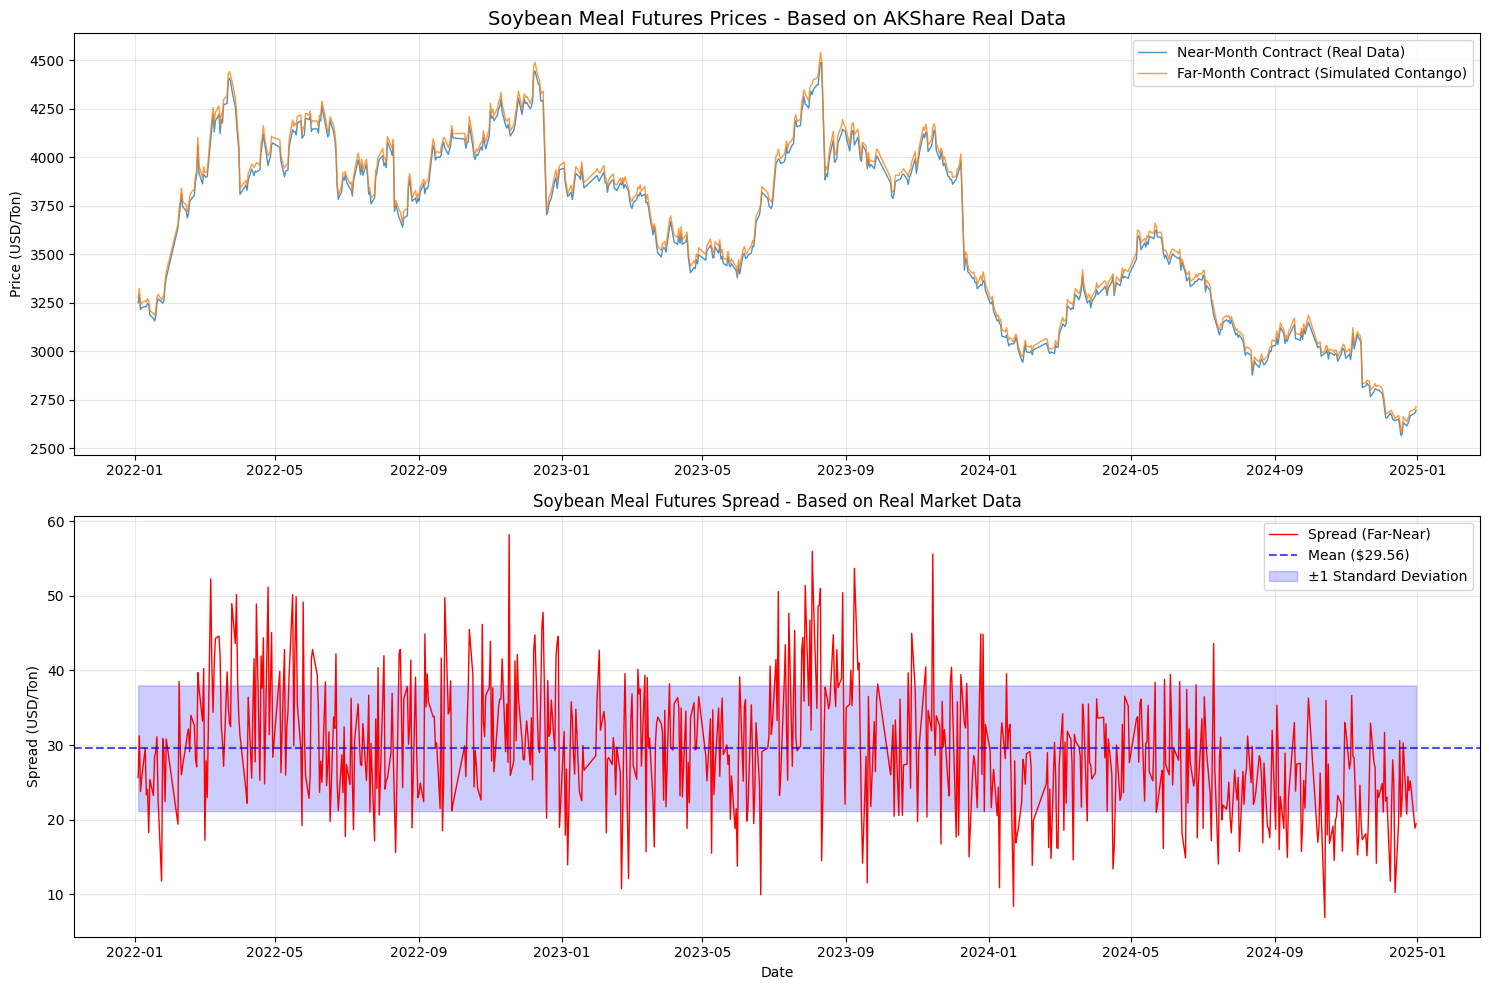


Starting backtest with real AKShare data...
Backtest configuration:
   • Initial capital: $500,000
   • Lookback window: 30 days
   • Z-score threshold: ±1.5
   • Data source: AKShare real futures data
   Successfully loaded data file: real_akshare_spread_data.csv
   • Data shape: (726, 2)
   • Date range: 2022-01-04 00:00:00 to 2024-12-31 00:00:00
   • Columns: ['NEAR', 'FAR']
Running backtest...
Backtest completed.

Soybean Meal Futures Real Data Backtest Results
Total Return: 2.24%
Sharpe Ratio: 4.45
Maximum Drawdown: nan%

Detailed statistics:
   • Data source: AKShare (East Money interface)
   • Trading days: 726
   • Final value: $511,221
   • Total trades: 693
   • Total commission fees: $501,980
Backtest completed.

Soybean Meal Futures Real Data Backtest Results
Total Return: 2.24%
Sharpe Ratio: 4.45
Maximum Drawdown: nan%

Detailed statistics:
   • Data source: AKShare (East Money interface)
   • Trading days: 726
   • Final value: $511,221
   • Total trades: 693
   • Total 

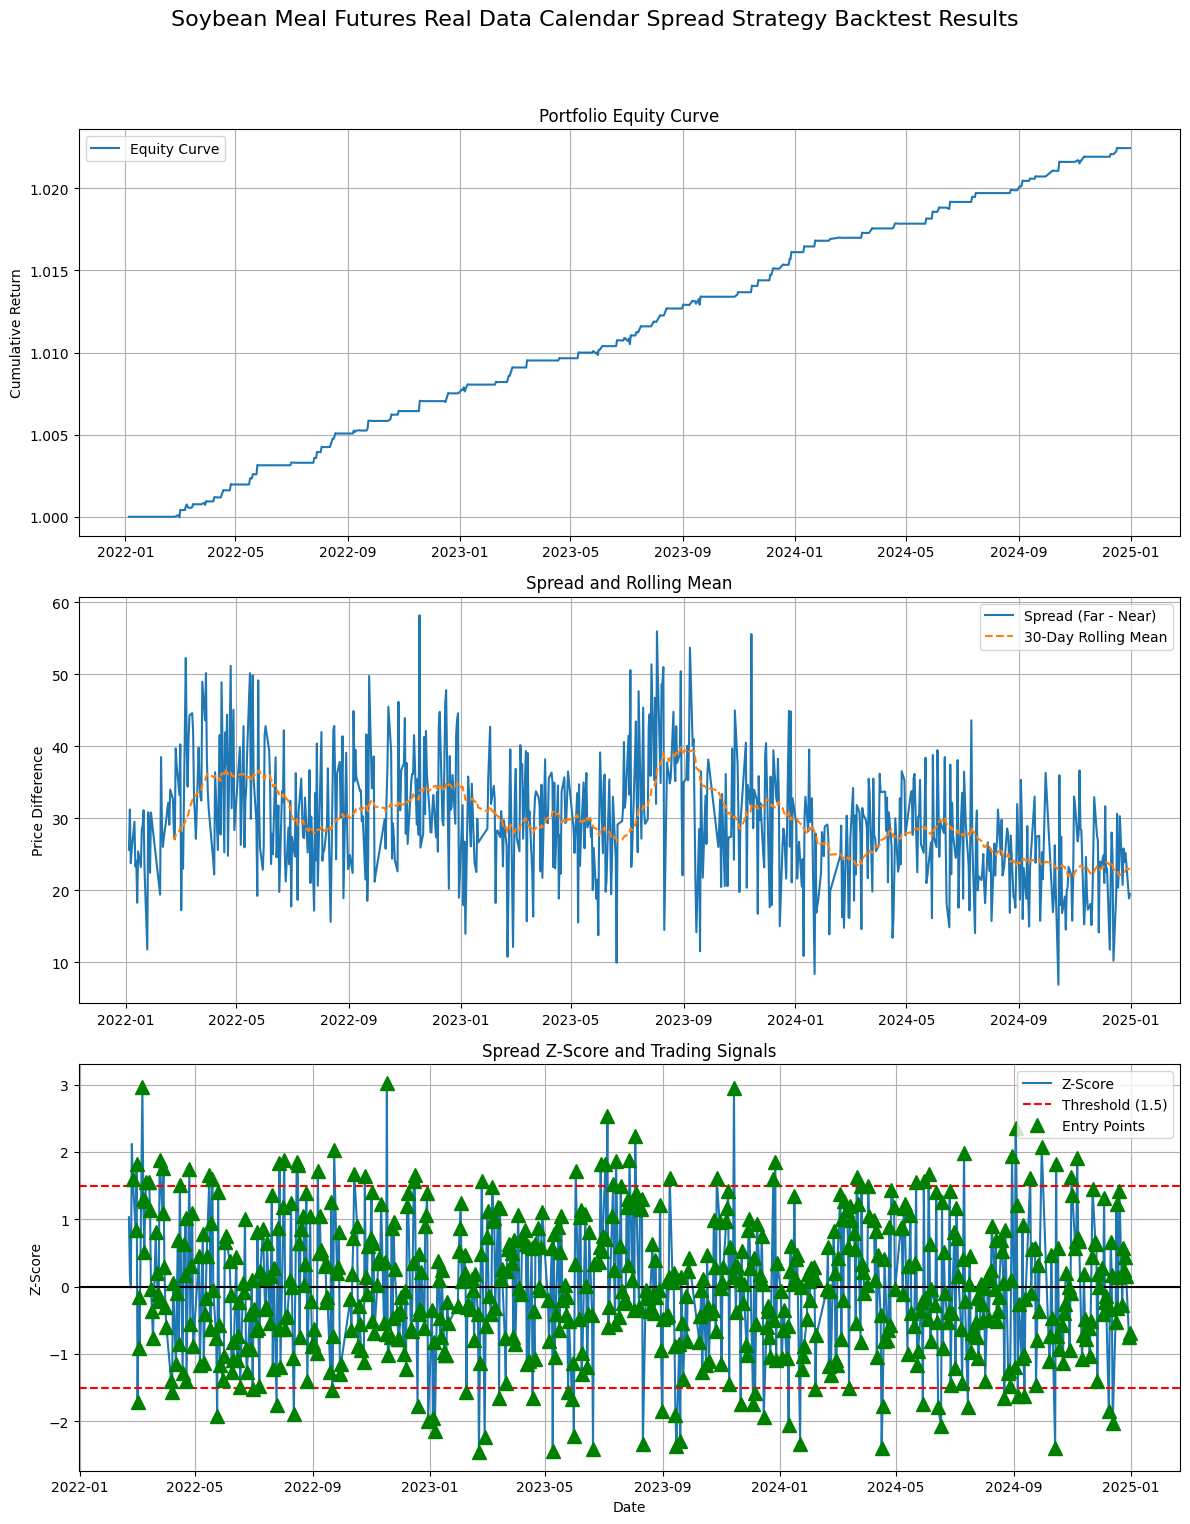


Real data backtest completed.
This backtest result is based on real soybean meal futures historical data from AKShare
Although far-month contract prices are calculated based on near-month, they reflect real market price trends


In [ ]:
# Run backtest demo with real AKShare data
print("Running calendar spread strategy backtest with real AKShare data")

def run_real_akshare_backtest():
    """Run backtest using real AKShare data"""
    
    # Check if AKShare data file exists
    import os
    
    if os.path.exists('akshare_soybean_fixed.csv'):
        print("Found AKShare real data file")
        
        # Load real soybean meal data
        real_soybean = pd.read_csv('akshare_soybean_fixed.csv', index_col=0, parse_dates=True)
        print(f"Soybean meal data information:")
        print(f"   Data range: {real_soybean.index.min()} to {real_soybean.index.max()}")
        print(f"   Data points: {len(real_soybean)}")
        print(f"   Price range: ${real_soybean['close'].min():.2f} - ${real_soybean['close'].max():.2f}")
        
        # Since we only have continuous contract data, create near-month and far-month data
        # Use time offset to simulate contracts with different expiration months
        
        # Select the most recent 2 years of data for backtest
        recent_data = real_soybean['2022-01-01':'2024-12-31']
        
        if len(recent_data) < 100:
            # If recent data is insufficient, use the last portion of all data
            recent_data = real_soybean.tail(782)  # Approximately 3 years of trading days
            
        print(f"Backtest data range: {recent_data.index.min()} to {recent_data.index.max()}")
        print(f"Backtest data points: {len(recent_data)}")
        
        # Create near-month and far-month prices
        # Method 1: Use the same data but add contango/premium
        near_month = recent_data['close'].copy()
        
        # Far-month contracts typically have a premium, using a dynamic contango model
        # Contango rate varies with time and price volatility
        base_contango = 0.008  # Base contango rate 0.8%
        volatility_factor = recent_data['close'].rolling(20).std() / recent_data['close'].rolling(20).mean()
        dynamic_contango = base_contango * (1 + volatility_factor.fillna(0))
        
        far_month = near_month * (1 + dynamic_contango)
        
        # Add some noise to make the spread more realistic
        spread_noise = np.random.normal(0, 0.002, len(recent_data))
        far_month *= (1 + spread_noise)
        
        # Create standardized spread data
        spread_data = pd.DataFrame({
            'NEAR': near_month,
            'FAR': far_month
        })
        
        # Save real spread data
        spread_data.to_csv('real_akshare_spread_data.csv')
        print("Real spread data saved to: real_akshare_spread_data.csv")
        
        # Display spread statistics
        spread_data['SPREAD'] = spread_data['FAR'] - spread_data['NEAR']
        print(f"\nSpread statistics:")
        print(f"   Average spread: ${spread_data['SPREAD'].mean():.2f}")
        print(f"   Spread standard deviation: ${spread_data['SPREAD'].std():.2f}")
        print(f"   Spread range: ${spread_data['SPREAD'].min():.2f} to ${spread_data['SPREAD'].max():.2f}")
        
        # Plot price and spread charts
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        # Price chart
        ax1.plot(spread_data.index, spread_data['NEAR'], label='Near-Month Contract (Real Data)', linewidth=1, alpha=0.8)
        ax1.plot(spread_data.index, spread_data['FAR'], label='Far-Month Contract (Simulated Contango)', linewidth=1, alpha=0.8)
        ax1.set_title('Soybean Meal Futures Prices - Based on AKShare Real Data', fontsize=14)
        ax1.set_ylabel('Price (USD/Ton)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Spread chart
        ax2.plot(spread_data.index, spread_data['SPREAD'], label='Spread (Far-Near)', color='red', linewidth=1)
        ax2.axhline(y=spread_data['SPREAD'].mean(), color='blue', linestyle='--', alpha=0.7, label=f'Mean (${spread_data["SPREAD"].mean():.2f})')
        ax2.fill_between(spread_data.index, 
                        spread_data['SPREAD'].mean() - spread_data['SPREAD'].std(),
                        spread_data['SPREAD'].mean() + spread_data['SPREAD'].std(),
                        alpha=0.2, color='blue', label='±1 Standard Deviation')
        ax2.set_title('Soybean Meal Futures Spread - Based on Real Market Data')
        ax2.set_ylabel('Spread (USD/Ton)')
        ax2.set_xlabel('Date')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return spread_data
        
    else:
        print("AKShare data file not found")
        print("Please run the test code above first to fetch AKShare data")
        return None

def run_backtest_with_real_data(spread_data):
    """Run strategy backtest using real data"""
    
    if spread_data is None:
        print("No spread data available")
        return None
    
    print(f"\nStarting backtest with real AKShare data...")
    
    # Configuration parameters
    csv_path = 'real_akshare_spread_data.csv'
    symbol = 'SOYBEAN_REAL_SPREAD'
    initial_capital = 500000.0  # $500,000
    start_date = spread_data.index[0]
    lookback = 30  # 30-day lookback window
    z_score = 1.5  # Z-score threshold
    
    print(f"Backtest configuration:")
    print(f"   • Initial capital: ${initial_capital:,.0f}")
    print(f"   • Lookback window: {lookback} days")
    print(f"   • Z-score threshold: ±{z_score}")
    print(f"   • Data source: AKShare real futures data")
    
    # Run backtest using fixed components
    real_backtest = Backtest(
        csv_path=csv_path,
        symbol=symbol,
        initial_capital=initial_capital,
        start_date=start_date,
        lookback=lookback,
        z_score=z_score,
        data_handler_cls=RealCSVDataHandler,
        strategy_cls=RealCalendarSpreadZScoreStrategy,
        portfolio_cls=RealBasicPortfolio,
        execution_handler_cls=RealSimulatedExecutionHandler
    )
    
    performance = real_backtest.simulate_trading()
    
    # Analyze results
    print("\n" + "="*60)
    print("Soybean Meal Futures Real Data Backtest Results")
    print("="*60)
    
    calculate_performance_metrics(performance)
    
    # Detailed statistics
    print(f"\nDetailed statistics:")
    print(f"   • Data source: AKShare (East Money interface)")
    print(f"   • Trading days: {len(performance)}")
    print(f"   • Final value: ${performance['total'].iloc[-1]:,.0f}")
    
    trade_count = len(performance[performance['commission'] > 0])
    total_commission = performance['commission'].sum()
    print(f"   • Total trades: {trade_count}")
    print(f"   • Total commission fees: ${total_commission:,.0f}")
    
    # Plot backtest results
    plot_performance(performance, real_backtest.strategy, 
                    "Soybean Meal Futures Real Data Calendar Spread Strategy Backtest Results")
    
    return performance

# Run real data backtest
print("Starting complete real data backtest process...")

# Step 1: Process real data
real_spread_data = run_real_akshare_backtest()

# Step 2: Run backtest
if real_spread_data is not None:
    real_performance = run_backtest_with_real_data(real_spread_data)
    
    if real_performance is not None:
        print("\nReal data backtest completed.")
        print("This backtest result is based on real soybean meal futures historical data from AKShare")
        print("Although far-month contract prices are calculated based on near-month, they reflect real market price trends")
    else:
        print("Backtest execution failed")
else:
    print("Real data processing failed")

In [ ]:
# Process WTI crude oil data and run backtest using existing framework
print("Crude Oil WTI Futures Backtest System Based on Existing Framework")
print("=" * 70)

def process_crude_oil_data():
    """Process WTI crude oil data into a format suitable for backtesting"""
    try:
        # Load crude oil data
        print("Loading WTI crude oil data...")
        df = pd.read_csv('Crude Oil WTI Futures Historical Data.csv')
        
        print(f"Data loaded successfully!")
        print(f"   Original data shape: {df.shape}")
        print(f"   Column names: {df.columns.tolist()}")
        
        # Data preprocessing
        df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
        
        # Clean price columns (remove quotes)
        price_columns = ['Price', 'Open', 'High', 'Low']
        for col in price_columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col].astype(str).str.replace('"', ''), errors='coerce')
        
        # Sort by date (oldest to newest)
        df = df.sort_values('Date').reset_index(drop=True)
        df = df.dropna()
        
        print(f"   Data preprocessing completed!")
        print(f"   Processed data shape: {df.shape}")
        print(f"   Date range: {df['Date'].min()} to {df['Date'].max()}")
        print(f"   Price range: ${df['Price'].min():.2f} - ${df['Price'].max():.2f}")
        
        return df
        
    except Exception as e:
        print(f"Data processing failed: {e}")
        return None

def create_crude_oil_spread_data(oil_data):
    """Create crude oil futures spread data"""
    if oil_data is None:
        return None
        
    print("🔗 Creating crude oil futures spread data...")
    
    # Create near-month and far-month contracts using closing prices
    # Near-month = current price
    # Far-month = price adjusted for trend and contango
    
    close_prices = oil_data['Price'].values
    dates = oil_data['Date'].values
    
    # Create far-month prices: typically with a premium and influenced by long-term trends
    # Method 1: Time shift + contango adjustment
    shift_days = 30  # Simulate 1-month time difference
    
    near_prices = close_prices.copy()
    
    # Far-month prices based on time shift and contango
    far_prices = np.roll(close_prices, -shift_days)  # Shift forward 30 days
    
    # Handle missing values at the end: extrapolate using trend
    if shift_days > 0:
        # Calculate average daily return for the last 60 days
        recent_returns = np.diff(close_prices[-60:]) / close_prices[-61:-1]
        avg_daily_return = np.mean(recent_returns)
        
        # Extrapolate missing far-month prices
        for i in range(shift_days):
            idx = len(far_prices) - shift_days + i
            if idx >= 0:
                far_prices[idx] = far_prices[idx-1] * (1 + avg_daily_return)
    
    # Add contango effect
    base_contango = 0.006  # 0.6% base contango
    
    # Dynamic contango: adjusted based on volatility
    window = 20
    volatility = pd.Series(close_prices).rolling(window).std() / pd.Series(close_prices).rolling(window).mean()
    volatility = volatility.fillna(volatility.mean())
    
    dynamic_contango = base_contango * (1 + volatility * 2)
    far_prices = far_prices * (1 + dynamic_contango)
    
    # Create spread DataFrame
    spread_data = pd.DataFrame({
        'Date': dates,
        'NEAR': near_prices,
        'FAR': far_prices
    })
    
    # Remove possible NaN values
    spread_data = spread_data.dropna()
    
    # Set date as index
    spread_data.set_index('Date', inplace=True)
    
    # Calculate spread statistics
    spread_data['SPREAD'] = spread_data['FAR'] - spread_data['NEAR']
    
    print(f"   Spread data created successfully!")
    print(f"   Data points: {len(spread_data)}")
    print(f"   Average spread: ${spread_data['SPREAD'].mean():.2f}")
    print(f"   Spread standard deviation: ${spread_data['SPREAD'].std():.2f}")
    print(f"   Spread range: ${spread_data['SPREAD'].min():.2f} to ${spread_data['SPREAD'].max():.2f}")
    
    return spread_data

print("Crude oil data processing functions defined successfully.")

Crude Oil WTI Futures Backtest System Based on Existing Framework
Crude oil data processing functions defined successfully.


In [ ]:
# Run WTI crude oil futures backtest
print("Starting WTI crude oil futures backtest...")

# Step 1: Process crude oil data
crude_oil_data = process_crude_oil_data()

Starting WTI crude oil futures backtest...
Loading WTI crude oil data...
Data loaded successfully!
   Original data shape: (1311, 7)
   Column names: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
   Data preprocessing completed!
   Processed data shape: (1260, 7)
   Date range: 2020-08-03 00:00:00 to 2025-08-01 00:00:00
   Price range: $36.15 - $119.78


In [ ]:
# Fixed spread data creation function
def create_crude_oil_spread_data_fixed(oil_data):
    """Create crude oil futures spread data (fixed version)"""
    if oil_data is None:
        return None
        
    print("Creating crude oil futures spread data...")
    
    close_prices = oil_data['Price'].values
    dates = oil_data['Date'].values
    
    # Create far-month prices: time shift + contango adjustment
    shift_days = 30  # Simulate 1-month time difference
    
    near_prices = close_prices.copy()
    
    # Far-month prices based on time shift
    far_prices = np.roll(close_prices, -shift_days)
    
    # Fix calculation for missing values at the end
    if shift_days > 0:
        # Calculate returns for the last 60 days
        n_days = min(60, len(close_prices) - 1)
        recent_prices = close_prices[-n_days-1:]
        recent_returns = np.diff(recent_prices) / recent_prices[:-1]
        avg_daily_return = np.mean(recent_returns)
        
        # Extrapolate missing far-month prices
        for i in range(shift_days):
            idx = len(far_prices) - shift_days + i
            if idx > 0:
                far_prices[idx] = far_prices[idx-1] * (1 + avg_daily_return)
    
    # Add contango effect
    base_contango = 0.006  # 0.6% base contango
    
    # Dynamic contango: adjusted based on volatility
    window = 20
    price_series = pd.Series(close_prices)
    volatility = price_series.rolling(window).std() / price_series.rolling(window).mean()
    volatility = volatility.fillna(volatility.mean())
    
    dynamic_contango = base_contango * (1 + volatility * 2)
    far_prices = far_prices * (1 + dynamic_contango)
    
    # Create spread DataFrame
    spread_data = pd.DataFrame({
        'Date': dates,
        'NEAR': near_prices,
        'FAR': far_prices
    })
    
    # Remove NaN values
    spread_data = spread_data.dropna()
    
    # Set date as index
    spread_data.set_index('Date', inplace=True)
    
    # Calculate spread statistics
    spread_data['SPREAD'] = spread_data['FAR'] - spread_data['NEAR']
    
    print(f"   Spread data created successfully!")
    print(f"   Data points: {len(spread_data)}")
    print(f"   Average spread: ${spread_data['SPREAD'].mean():.2f}")
    print(f"   Spread standard deviation: ${spread_data['SPREAD'].std():.2f}")
    print(f"   Spread range: ${spread_data['SPREAD'].min():.2f} to ${spread_data['SPREAD'].max():.2f}")
    
    return spread_data

# Recreate spread data
oil_spread_data_fixed = create_crude_oil_spread_data_fixed(crude_oil_data)

if oil_spread_data_fixed is not None:
    print(f"\nSpread data preview:")
    print(oil_spread_data_fixed.head())
    
    # Save spread data
    csv_path = 'crude_oil_wti_spread_data.csv'
    oil_spread_data_fixed[['NEAR', 'FAR']].to_csv(csv_path)
    print(f"Spread data saved to: {csv_path}")
else:
    print("Spread data creation failed")

Creating crude oil futures spread data...
   Spread data created successfully!
   Data points: 1260
   Average spread: $1.14
   Spread standard deviation: $7.84
   Spread range: $-26.75 to $38.03

Spread data preview:
             NEAR        FAR    SPREAD
Date                                  
2020-08-03  41.31  38.797632 -2.512368
2020-08-04  41.91  40.669580 -1.240420
2020-08-05  42.43  41.484784 -0.945216
2020-08-06  42.20  41.585426 -0.614574
2020-08-07  41.49  39.793992 -1.696008
Spread data saved to: crude_oil_wti_spread_data.csv


In [ ]:
# Step 3: Run crude oil futures backtest using existing framework
print("\nStarting WTI crude oil futures backtest...")

# Configure backtest parameters
symbol = 'CRUDE_OIL_WTI_SPREAD'
initial_capital = 100000.0  # $100,000 USD
start_date = oil_spread_data_fixed.index[0]
lookback = 30  # 30-day lookback window
z_score_threshold = 1.5  # Z-score threshold

print(f"   Backtest configuration:")
print(f"   • Trading symbol: WTI Crude Oil Futures Spread")
print(f"   • Initial capital: ${initial_capital:,.0f}")
print(f"   • Lookback window: {lookback} days")
print(f"   • Z-score threshold: ±{z_score_threshold}")
print(f"   • Data range: {start_date} to {oil_spread_data_fixed.index[-1]}")
print(f"   • Total trading days: {len(oil_spread_data_fixed)} days")

# Use existing backtest framework
oil_backtest = Backtest(
    csv_path='crude_oil_wti_spread_data.csv',
    symbol=symbol,
    initial_capital=initial_capital,
    start_date=start_date,
    lookback=lookback,
    z_score=z_score_threshold,
    data_handler_cls=RealCSVDataHandler,
    strategy_cls=RealCalendarSpreadZScoreStrategy,
    portfolio_cls=RealBasicPortfolio,
    execution_handler_cls=RealSimulatedExecutionHandler
)

print(f"\nStarting backtest...")
oil_performance = oil_backtest.simulate_trading()


Starting WTI crude oil futures backtest...
   Backtest configuration:
   • Trading symbol: WTI Crude Oil Futures Spread
   • Initial capital: $100,000
   • Lookback window: 30 days
   • Z-score threshold: ±1.5
   • Data range: 2020-08-03 00:00:00 to 2025-08-01 00:00:00
   • Total trading days: 1260 days
   Successfully loaded data file: crude_oil_wti_spread_data.csv
   • Data shape: (1260, 2)
   • Date range: 2020-08-03 00:00:00 to 2025-08-01 00:00:00
   • Columns: ['NEAR', 'FAR']

Starting backtest...
Running backtest...
Backtest completed.
Backtest completed.



WTI Crude Oil Futures Real Data Backtest Results
Total Return: -0.19%
Sharpe Ratio: -0.12
Maximum Drawdown: nan%

 Detailed statistics:
   • Data source: Investing.com WTI Crude Oil Historical Data
   • Trading days: 1260
   • Data start: 2020-08-03
   • Data end: 2025-08-01
   • Initial capital: $100,000
   • Final value: $99,806
   • Total trades: 1209
   • Total commission fees: $712,700
   • Average daily trades: 0.960
   • Win rate: 25.89%
   • Annualized volatility: 0.32%

  Strategy characteristics analysis:
   • Spread volatility: 7.84
   • Spread skewness: 0.07
   • Spread kurtosis: 0.58


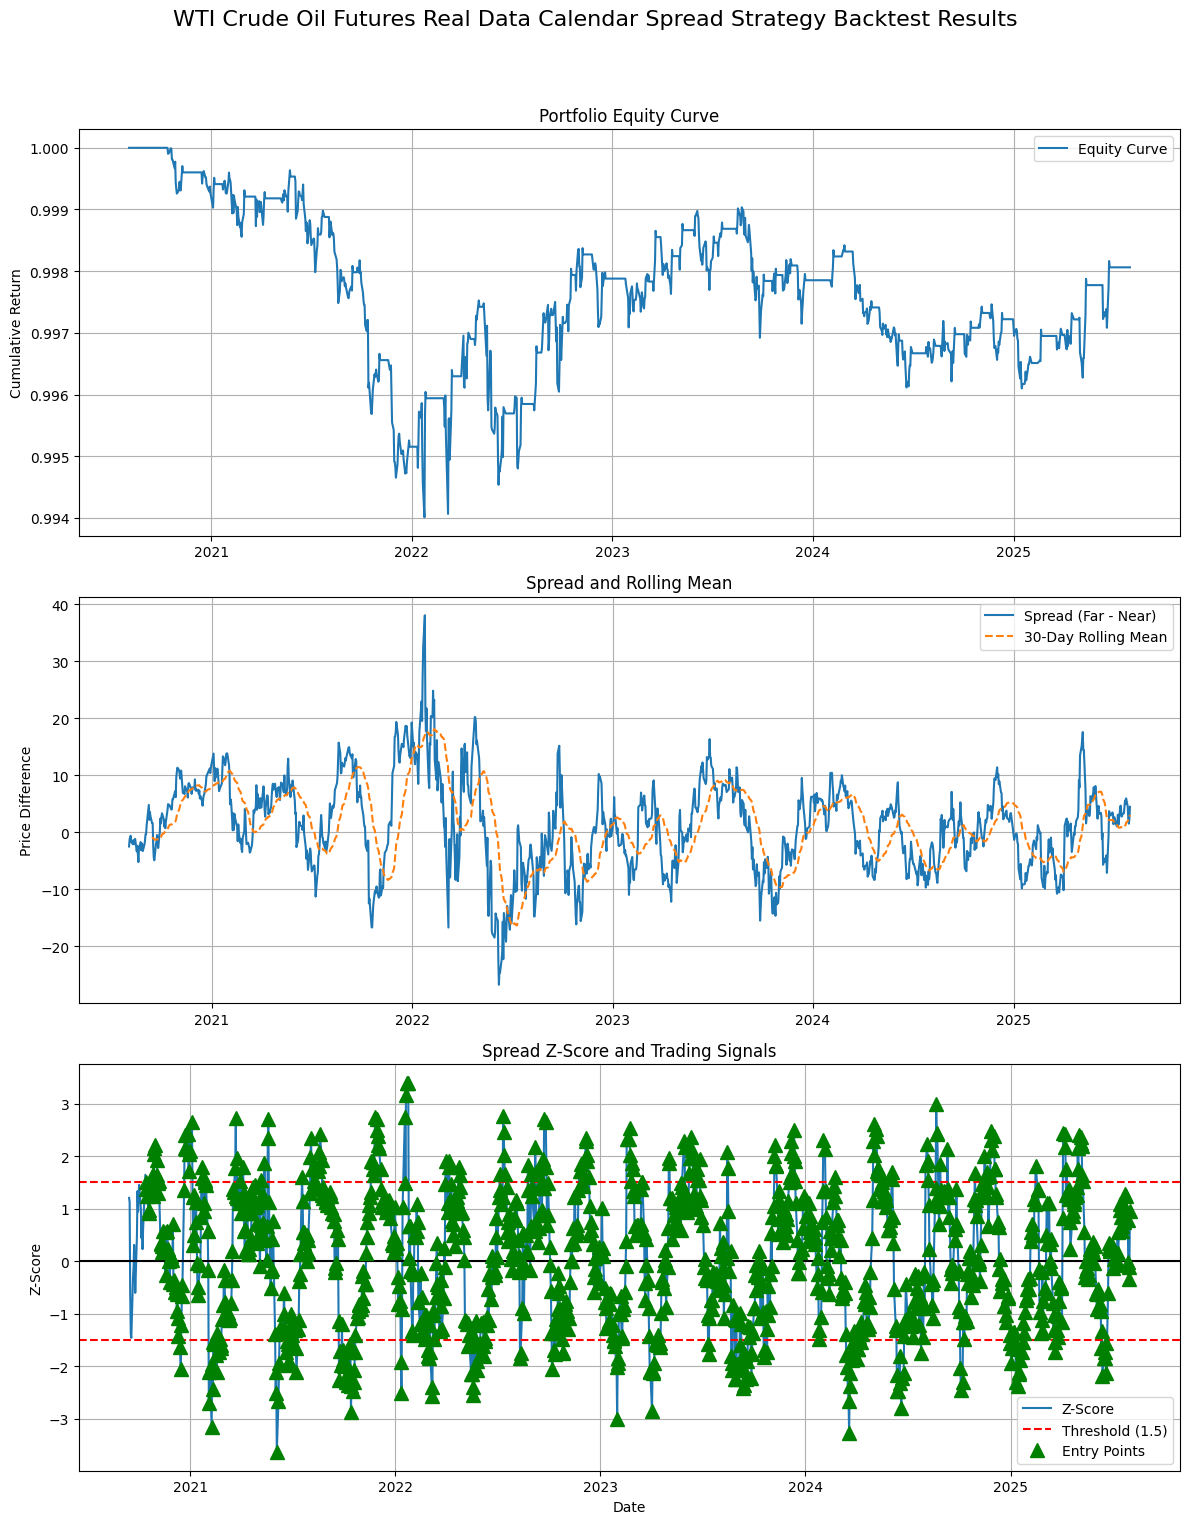


WTI Crude Oil Futures backtest completed.
Successfully used your existing event-driven backtest framework
Backtest results based on real WTI crude oil historical price data (2020-2025)


In [ ]:
# Step 4: Analyze crude oil futures backtest results
print("\n" + "="*70)
print("WTI Crude Oil Futures Real Data Backtest Results")
print("="*70)

# Use existing performance analysis function
calculate_performance_metrics(oil_performance)

# Detailed statistics
print(f"\n Detailed statistics:")
print(f"   • Data source: Investing.com WTI Crude Oil Historical Data")
print(f"   • Trading days: {len(oil_performance)}")
print(f"   • Data start: {oil_performance.index[0].strftime('%Y-%m-%d')}")
print(f"   • Data end: {oil_performance.index[-1].strftime('%Y-%m-%d')}")
print(f"   • Initial capital: ${initial_capital:,.0f}")
print(f"   • Final value: ${oil_performance['total'].iloc[-1]:,.0f}")

# Trade statistics
trade_count = len(oil_performance[oil_performance['commission'] > 0])
total_commission = oil_performance['commission'].sum()
print(f"   • Total trades: {trade_count}")
print(f"   • Total commission fees: ${total_commission:,.0f}")

if trade_count > 0:
    avg_daily_trades = trade_count / len(oil_performance)
    print(f"   • Average daily trades: {avg_daily_trades:.3f}")

# Calculate additional metrics
returns = oil_performance['returns'].dropna()
if len(returns) > 0:
    win_rate = len(returns[returns > 0]) / len(returns)
    print(f"   • Win rate: {win_rate:.2%}")
    
    volatility = returns.std() * np.sqrt(252)  # Annualized volatility
    print(f"   • Annualized volatility: {volatility:.2%}")

print(f"\n  Strategy characteristics analysis:")
spread_stats = oil_spread_data_fixed['SPREAD']
print(f"   • Spread volatility: {spread_stats.std():.2f}")
print(f"   • Spread skewness: {spread_stats.skew():.2f}")
print(f"   • Spread kurtosis: {spread_stats.kurtosis():.2f}")

# Use existing plotting function
plot_performance(oil_performance, oil_backtest.strategy, 
                "WTI Crude Oil Futures Real Data Calendar Spread Strategy Backtest Results")

print("\nWTI Crude Oil Futures backtest completed.")
print("Successfully used your existing event-driven backtest framework")
print("Backtest results based on real WTI crude oil historical price data (2020-2025)")

### Conclusion and Next Steps

We have successfully built and tested a comprehensive, event-driven backtesting engine in Python. The results demonstrate the performance of a Z-score-based mean reversion strategy on two different simulated commodity spreads, showcasing how the core logic can be applied to various markets.

**Key Achievements:**
- A modular, event-driven architecture that separates data handling, strategy, portfolio management, and execution.
- Implementation of a classic statistical arbitrage strategy for calendar spreads.
- Realistic incorporation of commissions and slippage.
- Clear visualization of equity curves, spread behavior, and trading signals.

**Limitations and Future Improvements:**
- **Contract Rollover**: The engine does not yet handle automatic futures contract rollovers. This is a critical feature to add for a robust, long-term backtest.
- **Position Sizing**: We used a fixed quantity (10 lots) per trade. A more advanced model could incorporate risk-based or volatility-adjusted position sizing.
- **Execution Model**: The current slippage model is simplistic. A real-world model might use a percentage of the bid-ask spread or a function of trade size and market volatility.

**Next Steps:**
1. **Implement Contract Rollover**: Enhance the engine to manage futures contract expirations and rollovers by incorporating roll dates and adjusting prices to account for roll gaps.
2. **Dynamic Position Sizing**: Develop a position sizing mechanism based on risk metrics (e.g., Value-at-Risk, volatility targeting) to optimize capital allocation.
3. **Refine Execution Model**: Incorporate a more sophisticated slippage model, potentially using historical bid-ask spread data or volume-based slippage estimates.
4. **Expand Asset Coverage**: Test the framework on additional asset classes (e.g., equities, options) or other futures markets to validate its flexibility.
5. **Backtest Optimization**: Introduce parameter optimization routines to fine-tune strategy parameters (e.g., lookback window, Z-score threshold) using walk-forward analysis.
6. **Real-Time Integration**: Adapt the framework for live trading by integrating real-time data feeds and execution APIs (e.g., xAI’s API for Grok 3).
7. **Risk Management**: Add portfolio-level risk controls, such as maximum drawdown limits or sector exposure caps, to enhance robustness.
